In [1]:
import sympy as sp
import numpy as np
import jax
jax.config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
import autoscattering.architecture_optimizer as arch_opt
import autoscattering.constraints as msc
import autoscattering.symbolic as sym

A directional coupler has two input (or more) input ports. The summed up signal from the inputs is scattered towards the output port.
Furthermore, we demand, that there is no scattering from the potentially noisy output to the input ports. This corresponds to the scattering matrix:

$S_\mathrm{target}=\begin{pmatrix}0&0&0\\ 0&0&0\\ t&t&0 \end{pmatrix}$

$t$ is a transmission rate and its value is left open for optimisation

In [2]:
t = sp.Symbol('t', real=True) # transmission rate
S_target = sp.Matrix([[0,0,0],[0,0,0],[t,t,0]])

For a new scattering behaviour it is not clear how many auxiliry modes are required to realise the requested behaviour. Let's try no auxiliary modes.

In [3]:
optimizer = arch_opt.Architecture_Optimizer(
    S_target=S_target,
    num_auxiliary_modes=0,
)

Exception: fully connected graph is invalid, interrupting

This does not work. Let's try one auxiliary mode.

In [4]:
optimizer = arch_opt.Architecture_Optimizer(
    S_target=S_target,
    num_auxiliary_modes=1,
)

Exception: fully connected graph is invalid, interrupting

Still not working. Let's try two auxiliary modes

In [5]:
optimizer = arch_opt.Architecture_Optimizer(
    S_target=S_target,
    num_auxiliary_modes=2,
)

fully connected graph is a valid graph


This works! Now, we can prune the fully connected graph to find the irreducible graphs. This might take a while (~25min)

In [6]:
irreducible_graphs = optimizer.perform_depth_first_search()

prepare list of all possible graphs


1889568it [00:03, 538275.58it/s]


1889568 graphs identified
start depth-first search
test all graphs with 25 degrees of freedom:


100%|██████████| 1/1 [00:00<00:00,  7.64it/s]


test all graphs with 24 degrees of freedom:


100%|██████████| 15/15 [00:00<00:00, 22.99it/s]


test all graphs with 23 degrees of freedom:


100%|██████████| 115/115 [00:03<00:00, 35.58it/s]


test all graphs with 22 degrees of freedom:


100%|██████████| 414/414 [00:10<00:00, 40.12it/s]


test all graphs with 21 degrees of freedom:


100%|██████████| 1110/1110 [00:36<00:00, 30.58it/s]


test all graphs with 20 degrees of freedom:


100%|██████████| 3111/3111 [01:21<00:00, 38.14it/s]


test all graphs with 19 degrees of freedom:


100%|██████████| 6274/6274 [03:07<00:00, 33.49it/s] 


test all graphs with 18 degrees of freedom:


100%|██████████| 9974/9974 [04:01<00:00, 41.37it/s] 


test all graphs with 17 degrees of freedom:


100%|██████████| 10438/10438 [03:03<00:00, 56.79it/s]


test all graphs with 16 degrees of freedom:


100%|██████████| 6610/6610 [02:32<00:00, 43.27it/s] 


test all graphs with 15 degrees of freedom:


100%|██████████| 2936/2936 [01:24<00:00, 34.69it/s] 


test all graphs with 14 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 13 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 12 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 11 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 10 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 9 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 8 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 7 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 6 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 5 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 4 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 3 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 2 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 1 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 0 degrees of freedom:


0it [00:00, ?it/s]

optimisation finished, list of irreducible graphs has 400 elements


Compare our optimisation (orange area) to a brute force search (gray area)

Even though our optimisation only tests around $1.3\times 10^4$ graphs we have found all valid graphs (namely all extensions of the graphs in the irreducible_graphs list)

number of tested graphs (orange area): 13089


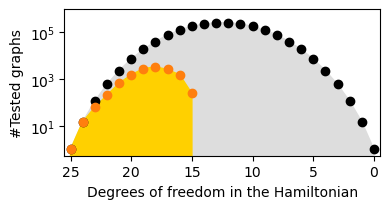

In [7]:
complexities, total_counts = np.unique(optimizer.complexity_levels, return_counts=True)
num_degrees_of_freedom_tested, total_counts_tested = np.hsplit(np.asarray(optimizer.tested_complexities), 2)

fig, ax = plt.subplots(figsize=(4,2.2))
ax.semilogy(complexities, total_counts, ls='None', marker='o', color='black')
ax.semilogy(num_degrees_of_freedom_tested, total_counts_tested, ls='None', marker='o', color='C1')
ax.fill_between(complexities, total_counts, interpolate=True, color='#DDDDDD')
ax.fill_between(num_degrees_of_freedom_tested[:,0], total_counts_tested[:,0], interpolate=True, color='#ffd000')

ax.set_xlim(25.5, -0.5)
ax.set_ylim(None, 10**6)
ax.set_yticks([10,1000,100000])
ax.set_xlabel('Degrees of freedom in the Hamiltonian')
ax.set_ylabel('#Tested graphs')
fig.tight_layout()
# print('number of possible graphs (gray area): %i'%optimizer.num_possible_graphs)
print('number of tested graphs (orange area): %i'%np.sum(total_counts_tested))

Characterise all found solutions

In [8]:
from multimode_systems.architecture import characterize_architectures
irreducible_graphs_info = characterize_architectures(optimizer.valid_combinations)

100%|██████████| 400/400 [00:00<00:00, 14179.41it/s]


Select and plot those graphs which have the lowest number of couplings

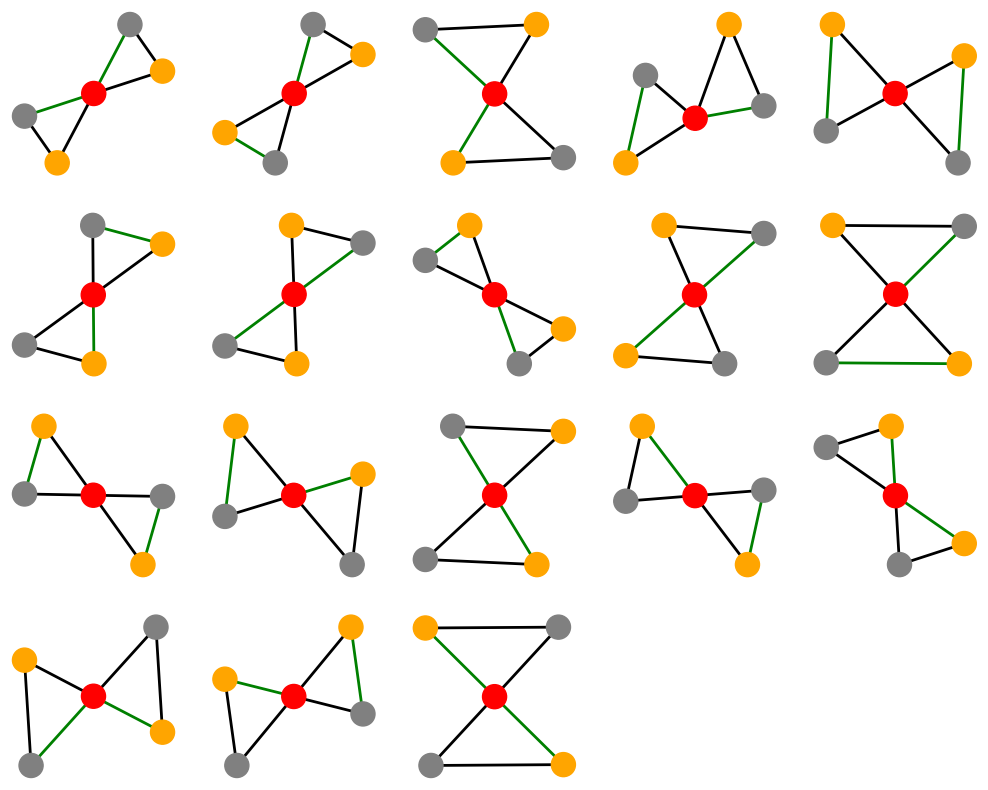

In [9]:
num_min_couplings = np.min(irreducible_graphs_info['num_couplings'])
idxs = np.where(irreducible_graphs_info['num_couplings'] == num_min_couplings)[0]
irreducible_graphs_min_couplings = irreducible_graphs[idxs]

node_colors = ['orange', 'orange', 'red', 'gray', 'gray'] # the input modes are orange, the output mode is red, the auxiliary modes are gray
msc.plot_list_of_graphs(irreducible_graphs_min_couplings, node_colors=node_colors)

Select those graphs which have the lowest number of complex couplings

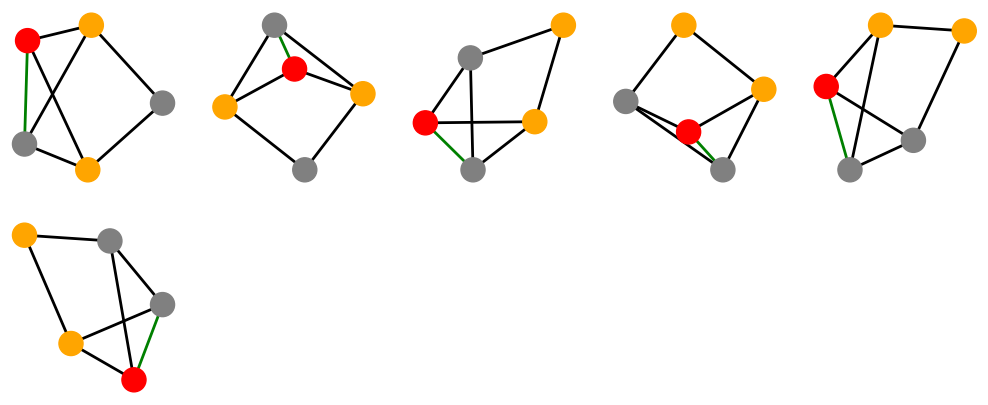

In [14]:
num_min_complex_couplings = np.min(irreducible_graphs_info['num_complex_couplings'])
idxs = np.where(irreducible_graphs_info['num_complex_couplings'] == num_min_complex_couplings)[0]
irreducible_graphs_min_complex_couplings = np.array(irreducible_graphs)[idxs]
node_colors = ['orange', 'orange', 'red', 'gray', 'gray'] # the input modes are orange, the output mode is red, the auxiliary modes are gray
msc.plot_list_of_graphs(irreducible_graphs_min_complex_couplings, node_colors=node_colors)